# Metal Surface Defect Classification using Convolutional Neural Networks

## Step1: Importing Libraries

In [55]:
# libraries for importing data
import os
import math
import statistics
from pathlib import Path
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# libraries for data augmentation
from natsort import natsorted, ns
from skimage import io
from skimage.transform import rotate

# importing basic libraries for data handling
import numpy as np
import matplotlib.pyplot as plt

# importing libraries for developing architecture of convolutional neural network with hyper-parameter tuning
import tensorflow as tf
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

# to visualise the model and classification results 
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report

## Step2: Establishing datapath

In [56]:
print("Enter datapath for training dataset")
train_data_folder = Path(str(input())) #path for training dataset
print("The path for training dataset is: ",train_data_folder)

Enter datapath for training dataset
The path for training dataset is:  D:\Group 11\Data\train


In [57]:
print("Enter datapath for test dataset")
test_data_folder = Path(str(input())) #path for test dataset
print("The path for test dataset is: ",test_data_folder)

Enter datapath for test dataset
The path for test dataset is:  D:\Group 11\Data\test


In [58]:
print("Enter datapath for validation dataset")
validation_data_folder = Path(str(input())) #path for validation dataset
print("The path for validation dataset is: ",validation_data_folder)

Enter datapath for validation dataset
The path for validation dataset is:  D:\Group 11\Data\valid


## Step3: Defining a function for Data Augmentation and Dataset Creation

In [59]:
def image_data(data_folder):
    """This function creates an augmented image array, a list of unique labels 
    of defects and respective encoded labels of each iamges.  
    Parameters
    ----------
    data_folder : path
        The given path for traing, testing and validation dataset.
    Returns
    ----------
    image_array, labels_array_true, labels_array_encoded : numpy array
        Returns numpy array for augmented images their respective encoded labels
        and true unique labels.
    """
    # read images class directories
    sns_path, sns_dirs, sns_files = next(os.walk(data_folder))
    sns_path1, sns_dirs1, sns_files1 = next(os.walk(sns_path / Path(sns_dirs[0])))
    sns_path2, sns_dirs2, sns_files2 = next(os.walk(sns_path / Path(sns_dirs[1])))
    sns_path3, sns_dirs3, sns_files3 = next(os.walk(sns_path / Path(sns_dirs[2])))
    sns_path4, sns_dirs4, sns_files4 = next(os.walk(sns_path / Path(sns_dirs[3])))
    sns_path5, sns_dirs5, sns_files5 = next(os.walk(sns_path / Path(sns_dirs[4])))
    sns_path6, sns_dirs6, sns_files6 = next(os.walk(sns_path / Path(sns_dirs[5])))
    
    sns_files_list = [sns_files1,sns_files2,sns_files3,sns_files4,sns_files5,sns_files6]
    sns_path_list = [sns_path1,sns_path2,sns_path3,sns_path4,sns_path5,sns_path6]
    
    rot_angle = [0,90,180,270] #roatation angles
    
    image_array_list = []
    labels = []

    for i in rot_angle:
        for l in sns_dirs:
            for j in sns_path_list:
                for k in sns_files_list:
                    try:
                        for filename in k:
                            img = io.imread(os.path.join(j, filename))
                            img_rot = rotate(img, i, cval=255)
                            if l in os.path.join(j, filename):
                                image_array_list.append(img_rot)
                                labels.append(l)
                    except:
                        pass
    labels_array = np.array(labels) #creating labels array
    labels_array_true, labels_array_encoded = np.unique(labels_array, return_inverse=True) #creating unique labels and encoded labels array
    image_array = np.array(image_array_list) #creating image dataset array
    return image_array, labels_array_true, labels_array_encoded

In [60]:
train_image_array, train_labels_array_true, train_labels_array_encoded = image_data(train_data_folder)

In [61]:
def test_val_image_data(data_folder):

    # read images class directories
    sns_path, sns_dirs, sns_files = next(os.walk(data_folder))
    sns_path1, sns_dirs1, sns_files1 = next(os.walk(sns_path / Path(sns_dirs[0])))
    sns_path2, sns_dirs2, sns_files2 = next(os.walk(sns_path / Path(sns_dirs[1])))
    sns_path3, sns_dirs3, sns_files3 = next(os.walk(sns_path / Path(sns_dirs[2])))
    sns_path4, sns_dirs4, sns_files4 = next(os.walk(sns_path / Path(sns_dirs[3])))
    sns_path5, sns_dirs5, sns_files5 = next(os.walk(sns_path / Path(sns_dirs[4])))
    sns_path6, sns_dirs6, sns_files6 = next(os.walk(sns_path / Path(sns_dirs[5])))
    
    sns_files_list = [sns_files1,sns_files2,sns_files3,sns_files4,sns_files5,sns_files6]
    sns_path_list = [sns_path1,sns_path2,sns_path3,sns_path4,sns_path5,sns_path6]
    
    rot_angle = [0] #roatation angles
    
    image_array_list = []
    labels = []

    for i in rot_angle:
        for l in sns_dirs:
            for j in sns_path_list:
                for k in sns_files_list:
                    try:
                        for filename in k:
                            img = io.imread(os.path.join(j, filename))
                            img_rot = rotate(img, i, cval=255)
                            if l in os.path.join(j, filename):
                                image_array_list.append(img_rot)
                                labels.append(l)
                    except:
                        pass
    labels_array = np.array(labels)
    labels_array_true, labels_array_encoded = np.unique(labels_array, return_inverse=True)
    image_array = np.array(image_array_list)
    #df=pd.DataFrame(image_array)
    #df['Target']=labels_array_encoded
    return image_array, labels_array_true, labels_array_encoded

In [62]:
test_image_array, test_labels_array_true, test_labels_array_encoded = test_val_image_data(test_data_folder)

In [63]:
validation_image_array, validation_labels_array_true, validation_labels_array_encoded = test_val_image_data(validation_data_folder)

## Step4: Defining function for CNN architecture with hyperparameters

In [64]:
def build_model_cnn2d(hp):
        """This function defines the base sequential model of CNN-2D for
        hyperparameter tuning.

        Parameters
        ----------
        hp : object
            It is the object of Keras hyperparameter tuner.

        Returns
        ----------
        CNN : json
            Returns tuned model parameters along with model architecture.
        """
        hp_units = hp.Int('units', min_value=48, max_value=128, step=8)

        CNN = Sequential()
        CNN.add(Conv2D(hp_units,(2,2), activation = 'relu', input_shape = (train_image_array.shape[1], train_image_array.shape[2], 1)))
        CNN.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
        CNN.add(MaxPooling2D(pool_size=(2, 2)))

        CNN.add(Conv2D(hp_units,(2,2), activation = 'relu'))
        CNN.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
        CNN.add(MaxPooling2D(pool_size=(2, 2)))

        CNN.add(Conv2D(hp_units,(2,2), activation = 'relu'))
        CNN.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
        CNN.add(MaxPooling2D(pool_size=(2, 2)))

        CNN.add(Conv2D(hp_units,(2,2), activation = 'relu'))
        CNN.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
        CNN.add(MaxPooling2D(pool_size=(2, 2)))

        CNN.add(Flatten())

        CNN.add(Dense(hp_units, activation=hp.Choice('dense_activation',values=['relu', 'tanh'],default='relu')))
        CNN.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))

        CNN.add(Dense(hp_units, activation=hp.Choice('dense_activation',values=['relu', 'tanh'],default='relu')))
        CNN.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))

        CNN.add(Dense(hp_units, activation=hp.Choice('dense_activation',values=['relu', 'tanh'],default='relu')))
        CNN.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))

        CNN.add(Dense(hp_units, activation=hp.Choice('dense_activation',values=['relu', 'tanh'],default='relu')))
        CNN.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))

        CNN.add(Dense(6, activation='softmax'))

        # Compile model
        CNN.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

        return CNN

## Step5: Deploying tuner for generating best model

In [65]:
tuner = kt.BayesianOptimization(build_model_cnn2d,
                     objective='val_loss',
                     max_trials=30,
                     directory='hyperparameter_defect_classfn',
                     project_name='kerastuner_epochs_2')

INFO:tensorflow:Reloading Oracle from existing project hyperparameter_defect_classfn\kerastuner_epochs_2\oracle.json
INFO:tensorflow:Reloading Tuner from hyperparameter_defect_classfn\kerastuner_epochs_2\tuner0.json


In [66]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [67]:
tuner.search(train_image_array, train_labels_array_encoded, validation_data = (test_image_array,test_labels_array_encoded), epochs= 30,callbacks=[stop_early])
model=tuner.get_best_models(num_models=1)[0] #getting best model

INFO:tensorflow:Oracle triggered exit


In [68]:
model.summary() # printing architecture of best model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 199, 199, 48)      240       
                                                                 
 dropout (Dropout)           (None, 199, 199, 48)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 48)        9264      
                                                                 
 dropout_1 (Dropout)         (None, 98, 98, 48)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 48)       0         
 2D)                                                    

### (Optional) Visualise the best model 

In [69]:
#!pip install graphviz
#visualizer(model, format='png', view=True) #visualising architecture for best model

## Step6: Fitting best model for augmented dataset

In [70]:
epochs = 30 #number of epochs for fit
history = model.fit(train_image_array, train_labels_array_encoded, validation_data = (test_image_array, test_labels_array_encoded), epochs=epochs)

Epoch 1/30
207/207 [==============================] - 90s 433ms/step - loss: 0.0720 - accuracy: 0.9758 - val_loss: 0.1003 - val_accuracy: 0.9583
Epoch 2/30
207/207 [==============================] - 89s 431ms/step - loss: 0.1733 - accuracy: 0.9449 - val_loss: 0.1540 - val_accuracy: 0.9306
Epoch 3/30
207/207 [==============================] - 90s 433ms/step - loss: 0.0688 - accuracy: 0.9751 - val_loss: 0.0586 - val_accuracy: 0.9861
Epoch 4/30
207/207 [==============================] - 90s 436ms/step - loss: 0.0934 - accuracy: 0.9663 - val_loss: 0.1295 - val_accuracy: 0.9444
Epoch 5/30
207/207 [==============================] - 91s 441ms/step - loss: 0.0718 - accuracy: 0.9733 - val_loss: 0.1834 - val_accuracy: 0.9444
Epoch 6/30
207/207 [==============================] - 93s 448ms/step - loss: 0.1075 - accuracy: 0.9626 - val_loss: 0.1321 - val_accuracy: 0.9722
Epoch 7/30
207/207 [==============================] - 95s 458ms/step - loss: 0.1459 - accuracy: 0.9577 - val_loss: 0.2337 - val_ac

In [71]:
def plot_learning_curve(history, epochs):
        """This function plots loss and accuracy of training and validation data.

        Parameters
        ----------
        history : object
            It contains the historical data of the model execution over the
            number of epochs.
        epochs : int
            A hyperparameter that defines the no of time the learning algorithm
            will work through entire training dataset.

        Returns
        ----------
        """

        # defining the range of the x axis
        epoch_range = range(1, epochs+1)

        # Plot training & validation accuracy values
        plt.plot(epoch_range, history.history['accuracy'])
        plt.plot(epoch_range, history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc='upper left')
        plt.show()

        # Plot training & validation loss values
        plt.plot(epoch_range, history.history['loss'])
        plt.plot(epoch_range, history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc='upper left')
        plt.show()

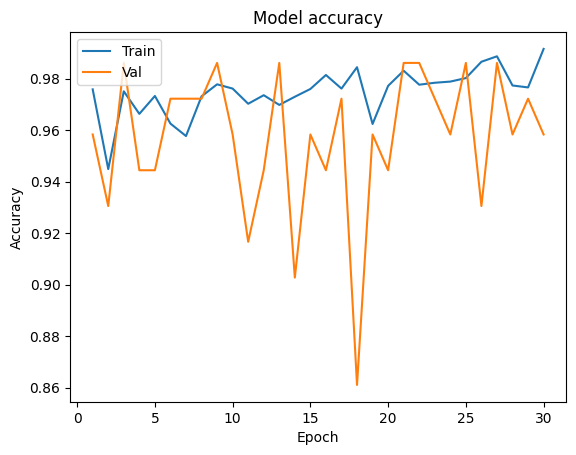

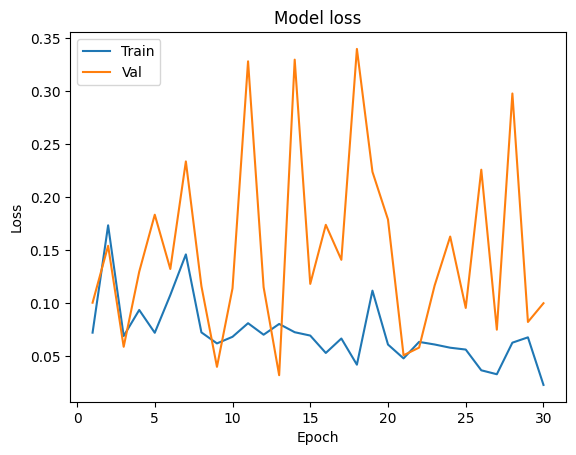

In [72]:
plot_learning_curve(history, epochs)

### Evalution of model for accuracy and loss

In [73]:
scores = model.evaluate(test_image_array, test_labels_array_encoded, verbose=0) #evaluates the model
print("***************************************************")
print(f"The best model is having {scores[0]} loss.")
print(f"The best model is {scores[1]*100}% accurate.")
print("***************************************************")

***************************************************
The best model is having 0.099762462079525 loss.
The best model is 95.83333134651184% accurate.
***************************************************


## Step7: Deploying model for test dataset and visualising reult with classification report and confusion matrix

In [74]:
test_labels_array_pred = np.argmax(model.predict(test_image_array), axis = 1) #predicts on test images

3/3 [==============================] - 0s 76ms/step


In [75]:
print("The classification report for test dataset is as follows:")
print("***************************************************************")
print(classification_report(test_labels_array_encoded,test_labels_array_pred))
print("***************************************************************")

The classification report for test dataset is as follows:
***************************************************************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.92      1.00      0.96        12
           2       1.00      1.00      1.00        12
           3       1.00      0.83      0.91        12
           4       0.92      0.92      0.92        12
           5       0.92      1.00      0.96        12

    accuracy                           0.96        72
   macro avg       0.96      0.96      0.96        72
weighted avg       0.96      0.96      0.96        72

***************************************************************


The confusion matrix for test dataset is as follows:


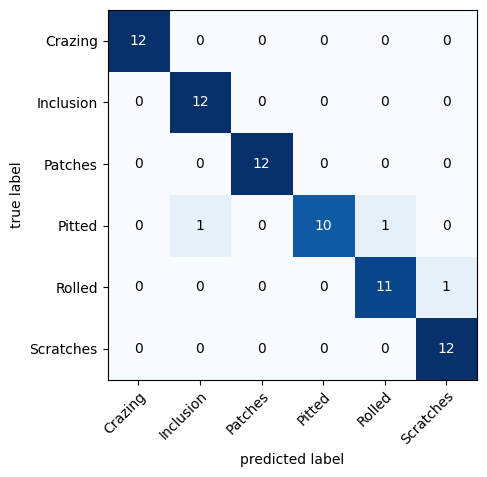

In [76]:
print("The confusion matrix for test dataset is as follows:")
cm_test_data = confusion_matrix(test_labels_array_encoded, 
                      test_labels_array_pred, 
                      binary=False)

fig, ax = plot_confusion_matrix(conf_mat=cm_test_data, 
                                class_names=test_labels_array_true)
plt.show()

## Step8: Deploying model for validation dataset and visualising reult with classification report and confusion matrix

In [77]:
validation_labels_array_pred = np.argmax(model.predict(validation_image_array), axis = 1) #predicts validation images data

3/3 [==============================] - 0s 78ms/step


In [78]:
print("The classification report for validation dataset is as follows:")
print("***************************************************************")
print(classification_report(validation_labels_array_encoded,validation_labels_array_pred)) 
print("***************************************************************")

The classification report for validation dataset is as follows:
***************************************************************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00        12

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72

***************************************************************


The confusion matrix for test dataset is as follows:


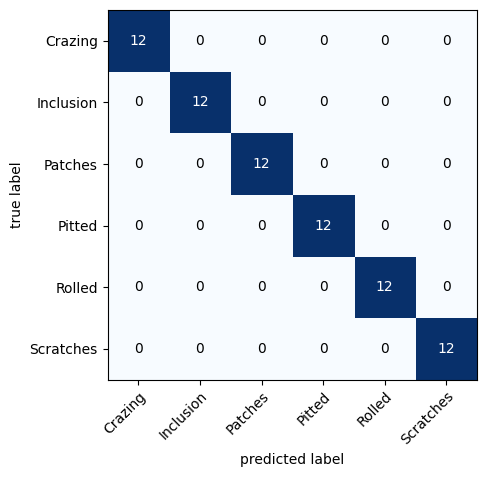

In [79]:
print("The confusion matrix for test dataset is as follows:")
cm_validation_data = confusion_matrix(validation_labels_array_encoded, 
                      validation_labels_array_pred, 
                      binary=False)

fig, ax = plot_confusion_matrix(conf_mat=cm_validation_data, 
                                class_names=validation_labels_array_true)
plt.show()

### If only validation data is to be used then use following function only for validation data folder

In [80]:
#def validation_image_data(data_folder):
#
#    # read images class directories
#    sns_path, sns_dirs, sns_files = next(os.walk(data_folder))
#    sns_path1, sns_dirs1, sns_files1 = next(os.walk(sns_path / Path(sns_dirs[0])))
#    sns_path2, sns_dirs2, sns_files2 = next(os.walk(sns_path / Path(sns_dirs[1])))
#    sns_path3, sns_dirs3, sns_files3 = next(os.walk(sns_path / Path(sns_dirs[2])))
#    sns_path4, sns_dirs4, sns_files4 = next(os.walk(sns_path / Path(sns_dirs[3])))
#    sns_path5, sns_dirs5, sns_files5 = next(os.walk(sns_path / Path(sns_dirs[4])))
#    sns_path6, sns_dirs6, sns_files6 = next(os.walk(sns_path / Path(sns_dirs[5])))
#    
#    sns_files_list = [sns_files1,sns_files2,sns_files3,sns_files4,sns_files5,sns_files6]
#    sns_path_list = [sns_path1,sns_path2,sns_path3,sns_path4,sns_path5,sns_path6]
#    rot_angle = [360]
#    
#    image_array_list = []
#    labels = []
#
#    for i in rot_angle:
#        for l in sns_dirs:
#            for j in sns_path_list:
#                for k in sns_files_list:
#                    try:
#                        for filename in k:
#                            img = io.imread(os.path.join(j, filename))
#                            img_rot = rotate(img, i, cval=255)
#                            if l in os.path.join(j, filename):
#                                image_array_list.append(img_rot)
#                                labels.append(l)
#                    except:
#                        pass
#    labels_array = np.array(labels)
#    labels_array_true, labels_array_encoded = np.unique(labels_array, return_inverse=True)
#    image_array = np.array(image_array_list)
#    #df=pd.DataFrame(image_array)
#    #df['Target']=labels_array_encoded
#    return image_array, labels_array_true, labels_array_encoded